# Where should you locate your Craft Brewery?

## Install packages

In [7]:
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library
from bs4 import BeautifulSoup as bsoup
import requests as req
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
%matplotlib inline 

In [8]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Load data on income, population, and jobs

In [9]:
df1 = pd.read_csv('PC_Personal_Income_Population_Employment_by_Metro.csv', skiprows=range(4))

df1 = df1.pivot_table(index=['GeoFips','GeoName'], columns='Description', values='2017').reset_index()

df1.columns
df1['Jobs-Population Ratio'] = df1['Total employment (number of jobs)']/df1['  Population (persons)']
df1[df1['GeoFips']==10180]

Description  GeoFips                                      GeoName  \
1              10180  Abilene, TX (Metropolitan Statistical Area)   

Description    Per capita personal income    Population (persons)  \
1                                 41326.0                170219.0   

Description  Total employment (number of jobs)  Jobs-Population Ratio  
1                                     103969.0               0.610796

In [31]:
df1[df1['GeoFips']==35620]

Description  GeoFips                                            GeoName  \
250            35620  New York-Newark-Jersey City, NY-NJ-PA (Metropo...   

Description    Per capita personal income    Population (persons)  \
250                               71019.0              20320876.0   

Description  Total employment (number of jobs)  Jobs-Population Ratio  
250                                 12982906.0               0.638895

## Load data on latitude and longitude, education, and density

In [10]:
df2 = pd.read_excel('Educational Attainment by Metro.xlsx', sheet_name='All Data')
df2['LandAreaSqMiles'] = df2['LandArea']*0.3861021585/1000000
df2 = df2.drop(columns=['Type',"Name","Population 25 years and over (Estimate)",
                        ' Percentage of population 25 years and over with an Associate\'s degree',
                        'Percentage of population 25 years and over with a Bachelor\'s degree',
                        'Percentage of population 25 years and over with a graduate or professional degree',
                        'LandArea'])

#df2.head()
df2[df2['FIPS']==10180]

FIPS   Latitude  Longitude  \
2  10180  32.448736 -99.733144   

   Percentage of population 25 years and over with at least a Bachelor's degree (BA+)  \
2                                               21.5                                    

   PopDensity  HousingDensity  LandAreaSqMiles  
2   60.234516       25.413373       2743.47796

In [440]:
df2[df2['FIPS']==35620]

FIPS   Latitude  Longitude  \
616  35620  40.712784 -74.005941   

     Percentage of population 25 years and over with at least a Bachelor's degree (BA+)  \
616                                               38.7                                    

      PopDensity  HousingDensity  LandAreaSqMiles  
616  2825.990778     1125.746681      6686.899654

## Load data on age and sex

In [11]:
df3 = pd.read_excel('AgeGroups by CBSA.xlsx', sheet_name='Sheet2')
df3[df3['GeoFips']==10180]

GeoFips  PercentFemale  Percent25_44
0    10180      49.369231     25.868047

### Join the three tables

In [12]:
determinants = df1.join(df2.set_index('FIPS'), on='GeoFips', how = 'inner')
determinants = determinants.dropna()
determinants = determinants.join(df3.set_index('GeoFips'), on='GeoFips', how = 'inner')
determinants[determinants['GeoFips']==10180]

GeoFips                                      GeoName  \
1    10180  Abilene, TX (Metropolitan Statistical Area)   

     Per capita personal income    Population (persons)  \
1                       41326.0                170219.0   

   Total employment (number of jobs)  Jobs-Population Ratio   Latitude  \
1                           103969.0               0.610796  32.448736   

   Longitude  \
1 -99.733144   

   Percentage of population 25 years and over with at least a Bachelor's degree (BA+)  \
1                                               21.5                                    

   PopDensity  HousingDensity  LandAreaSqMiles  PercentFemale  Percent25_44  
1   60.234516       25.413373       2743.47796      49.369231     25.868047

In [617]:
determinants[determinants['GeoFips']==35620]

GeoFips                                            GeoName  \
250    35620  New York-Newark-Jersey City, NY-NJ-PA (Metropo...   

       Per capita personal income    Population (persons)  \
250                       71019.0              20320876.0   

     Total employment (number of jobs)  Jobs-Population Ratio   Latitude  \
250                         12982906.0               0.638895  40.712784   

     Longitude  \
250 -74.005941   

     Percentage of population 25 years and over with at least a Bachelor's degree (BA+)  \
250                                               38.7                                    

      PopDensity  HousingDensity  LandAreaSqMiles  PercentFemale  Percent25_44  
250  2825.990778     1125.746681      6686.899654      51.649972     27.843063

In [21]:
print(determinants.shape)
determinants.head()
determinants.to_csv(r'BrewDeterminants.csv')

(369, 14)


## Foursquare Data

In [14]:
CLIENT_ID = 'IA44NH1GVQV5OTMYIXR4Q2LHHWHTCGHURWHPECLJ3IB3CAMB' # your Foursquare ID
CLIENT_SECRET = 'JDHQIX3KV4MVGKBU4KK31ADXKH2FWR5XY5G4MJGVE3VYH3VV' # your Foursquare Secret
VERSION = '20190605' # Foursquare API version
LIMIT = 100
#radius=15000

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IA44NH1GVQV5OTMYIXR4Q2LHHWHTCGHURWHPECLJ3IB3CAMB
CLIENT_SECRET:JDHQIX3KV4MVGKBU4KK31ADXKH2FWR5XY5G4MJGVE3VYH3VV


In [92]:
CategoryID = '50327c8591d4c4b30a586d5d'
    # Brewery
print(CategoryID + ' .... OK!')

50327c8591d4c4b30a586d5d .... OK!


In [82]:
# Testing it, just with Abilene, TX

x = determinants.loc[2,'GeoFips']
latitude = determinants.loc[determinants['GeoFips'] == x, 'Latitude'].iloc[0]
longitude = determinants.loc[determinants['GeoFips'] == x, 'Longitude'].iloc[0]
print(latitude,longitude)

#url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET, 
            latitude,
            longitude,
            VERSION,
            CategoryID,
            LIMIT)
url
results = req.get(url).json()["response"]['venues']
results


41.0814447 -81.5190053


[{'id': '5aefb388d807ee002c97889e',
  'name': 'Akronym  Brewing',
  'location': {'address': '58 E Market St',
   'lat': 41.084795,
   'lng': -81.515894,
   'labeledLatLngs': [{'label': 'display',
     'lat': 41.084795,
     'lng': -81.515894}],
   'distance': 455,
   'postalCode': '44308',
   'cc': 'US',
   'city': 'Akron',
   'state': 'OH',
   'country': 'United States',
   'formattedAddress': ['58 E Market St', 'Akron, OH 44308', 'United States']},
  'categories': [{'id': '50327c8591d4c4b30a586d5d',
    'name': 'Brewery',
    'pluralName': 'Breweries',
    'shortName': 'Brewery',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/brewery_',
     'suffix': '.png'},
    'primary': True}],
  'referralId': 'v-1561067010',
  'hasPerk': False},
 {'id': '5b043cf12619ee0037f4c706',
  'name': 'Shale Brewing Company',
  'location': {'address': '7253 Whipple Ave NW',
   'lat': 40.8865683,
   'lng': -81.4242964,
   'labeledLatLngs': [{'label': 'display',
     'lat': 40.8865683,


In [83]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#venues = results['response']['venues']
    
nearby_venues = json_normalize(results) # flatten JSON

# filter columns
filtered_columns = ['name', 'categories', 'location.lat', 'location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(30)

name categories        lat        lng
0              Akronym  Brewing    Brewery  41.084795 -81.515894
1         Shale Brewing Company    Brewery  40.886568 -81.424296
2                   Bent Ladder     Winery  40.970113 -81.696546
3            Magic City Brewing    Brewery  41.014928 -81.607353
4        Ignite Brewing Company    Brewery  41.012849 -81.611926
5              Hop Tree Brewing    Brewery  41.209179 -81.445047
6     Wadsworth Brewing Company    Brewery  41.025003 -81.729866
7   Missing Mountain Brewing Co    Brewery  41.148519 -81.468536
8   BJ's Restaurant & Brewhouse       None  41.131359 -81.615149
9          Hoppin' Frog Brewery        Bar  41.024527 -81.467586
10               R.Shea Brewing    Brewery  41.133473 -81.549344
11        The Brickoven Brewpub    Brewery  41.047155 -81.437324
12            Sully's Irish Pub        Bar  41.139217 -81.864753
13  Royal Docks Brewing Company    Brewery  40.858300 -81.482853
14       Canton Brewing Company    Brewery  40.799887 -81.374981
15       The Brew Kettle Hudson    Brewery  41.240242 -81.445872
16         McCarthurs Brewhouse        Bar  41.146317 -81.471631
17              Mad Cap Brewing    Brewery  41.138476 -81.372515
18           Blue Heron Brewery    Brewery  41.112620 -81.803920
19            Head Trip Brewery    Brewery  41.201609 -81.437065
20          Lock 15 Brewing Co.    Brewery  41.091443 -81.517169
21          Mucky Duck Brew Pub    Brewery  40.977906 -81.520550
22            Two Monks Brewing    Brewery  41.052190 -81.462830
23        Thirsty Dog Sour Haus    Brewery  41.068882 -81.516720
24           Fat Head's Brewery    Brewery  40.860577 -81.419378
25     Brewsters Bistro and Pub    Brewery  41.307261 -81.437517
26             HiHO Brewing Co.    Brewery  41.128167 -81.484812
27          The Vine n Hop Shop  Wine Shop  41.241013 -81.806924
28  Lager Heads Brewing Company    Brewery  41.136414 -81.869406
29      Muskellunge Brewing Co.    Brewery  40.801920 -81.377000

In [47]:
determinants['GeoFips'].head()

1    10180
2    10420
3    10500
4    10540
5    10580
Name: GeoFips, dtype: int64

In [93]:
def getNearbyVenues(geofips):
    
    venues_list=[]
    for fip in geofips:
        name = determinants.loc[determinants['GeoFips'] == fip, 'GeoName'].iloc[0]
        latitude = determinants.loc[determinants['GeoFips'] == fip, 'Latitude'].iloc[0]
        longitude = determinants.loc[determinants['GeoFips'] == fip, 'Longitude'].iloc[0]
        print(name, "(",longitude,",", latitude,")")

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, CategoryID, LIMIT)
            
        # make the GET request
        results = req.get(url).json()["response"]['venues']

        # return only relevant information for each nearby venue
        for v in results:
            venues_list.append([(
                fip,
                name, 
                latitude, 
                longitude, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
#                v['categories'][0]['name']
            )])
            
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['GeoFips',
                  'GeoName', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
#                  'Category'
                            ]
    
    return(nearby_venues)

# code to run the above function on each neighborhood and create a new dataframe called breweries.

breweries = getNearbyVenues(geofips=[47900])
#breweries = getNearbyVenues(geofips=[10180,10420,10500,10540,10580])
#breweries = getNearbyVenues(geofips=determinants['GeoFips'])

Washington-Arlington-Alexandria, DC-VA-MD-WV (Metropolitan Statistical Area)* ( -77.0368707 , 38.9071923 )


In [94]:
### print(breweries.shape)
#breweries = breweries[breweries.Category == "Brewery"]
#brewcount = brewcount.drop(['Latitude', 'Longitude'], axis=1)
print(breweries.shape)
breweries.to_csv(r'breweries.csv')
breweries.head(30)

(50, 7)


GeoFips                                            GeoName   Latitude  \
0     47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
1     47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
2     47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
3     47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
4     47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
5     47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
6     47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
7     47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
8     47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
9     47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
10    47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
11    47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
12    47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
13    47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
14    47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
15    47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
16    47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
17    47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
18    47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
19    47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
20    47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
21    47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
22    47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
23    47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
24    47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
25    47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
26    47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
27    47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
28    47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   
29    47900  Washington-Arlington-Alexandria, DC-VA-MD-WV (...  38.907192   

    Longitude                              Venue  Venue Latitude  \
0  -77.036871       Capitol City Brewing Company       38.899993   
1  -77.036871           Silver Branch Brewing Co       38.995004   
2  -77.036871                     Lost Boy Cider       38.798718   
3  -77.036871               Denizens Brewing Co.       38.969896   
4  -77.036871                  Astro Lab Brewery       38.992113   
5  -77.036871       True Respite Brewing Company       39.107872   
6  -77.036871                 Audacious Aleworks       38.880311   
7  -77.036871       Settle Down Easy Brewing Co.       38.876236   
8  -77.036871           Streetcar 82 Brewing Co.       38.949306   
9  -77.036871        Heritage Brewpub & Roastery       38.888180   
10 -77.036871                         Franklin's       38.952637   
11 -77.036871  Gordon Biersch Brewery Restaurant       38.917448   
12 -77.036871                  The Public Option       38.926124   
13 -77.036871                 Bluejacket Brewery       38.875049   
14 -77.036871            Mad Fox Brewing Company       38.886349   
15 -77.036871        BJ's Restaurant & Brewhouse       38.912634   
16 -77.036871  Gordon Biersch Brewery Restaurant       38.876800   
17 -77.036871                  Sweetwater Tavern       38.866512   
18 -77.036871        BJ's Restaurant & Brewhouse       39.092992   
19 -77.036871   Rock Bottom Restaurant & Brewery       38.988923   
20 -77.036871                      Bardo Brewpub       38.870149   
21 -77.036871         Black Flag Brewing Company       39.174600   
22 -77.036871                   Atlas Brew Works    

In [33]:
brewvenues = breweries[['GeoFips','Venue']]
brewvenues = brewvenues.rename(index=str, columns={"Venue": "Number of Breweries"})
brewcount = pd.DataFrame(brewvenues.groupby('GeoFips').count())
brewcount = brewcount.reset_index()
brewcount.to_csv(r'brewcount.csv')
brewcount.head(10)

GeoFips  Number of Breweries
0    10180                   12
1    10420                   43
2    10500                    2
3    10540                   27
4    10580                   41
5    10740                   50
6    10780                    1
7    10900                   50
8    11020                   10
9    11100                    4

### Bars

In [28]:
CategoryID = '4bf58dd8d48988d116941735'
    # Bars
print(CategoryID + ' .... OK!')

4bf58dd8d48988d116941735 .... OK!


In [29]:
def getNearbyVenues(geofips):
    
    venues_list=[]
    for fip in geofips:
        name = determinants.loc[determinants['GeoFips'] == fip, 'GeoName'].iloc[0]
        latitude = determinants.loc[determinants['GeoFips'] == fip, 'Latitude'].iloc[0]
        longitude = determinants.loc[determinants['GeoFips'] == fip, 'Longitude'].iloc[0]
        print(name, "(",longitude,",", latitude,")")

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, CategoryID, LIMIT)
            
        # make the GET request
        results = req.get(url).json()["response"]['venues']

        # return only relevant information for each nearby venue
        for v in results:
            venues_list.append([(
                fip,
                name, 
                latitude, 
                longitude, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
#                v['categories'][0]['name']
            )])
            
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['GeoFips',
                  'GeoName', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
#                  'Category'
                            ]
    
    return(nearby_venues)

# code to run the above function on each neighborhood and create a new dataframe called nightlifespots.

#bars = getNearbyVenues(geofips=[10420])
#bars = getNearbyVenues(geofips=[10180,10420,10500,10540,10580])
bars = getNearbyVenues(geofips=determinants['GeoFips'])

Abilene, TX (Metropolitan Statistical Area) ( -99.7331439 , 32.4487364 )
Akron, OH (Metropolitan Statistical Area) ( -81.5190053 , 41.0814447 )
Albany, GA (Metropolitan Statistical Area) ( -84.1557409999999 , 31.5785074 )
Albany, OR (Metropolitan Statistical Area) ( -123.1059282 , 44.6365107 )
Albany-Schenectady-Troy, NY (Metropolitan Statistical Area) ( -73.7562317 , 42.6525793 )
Albuquerque, NM (Metropolitan Statistical Area)* ( -106.609990999999 , 35.110703 )
Alexandria, LA (Metropolitan Statistical Area) ( -92.4451371 , 31.3112936 )
Allentown-Bethlehem-Easton, PA-NJ (Metropolitan Statistical Area) ( -75.4901833 , 40.6084305 )
Altoona, PA (Metropolitan Statistical Area) ( -78.3947359 , 40.5186809 )
Amarillo, TX (Metropolitan Statistical Area) ( -101.831296899999 , 35.2219971 )
Ames, IA (Metropolitan Statistical Area) ( -93.62 , 42.034722 )
Anchorage, AK (Metropolitan Statistical Area) ( -149.9002778 , 61.2180556 )
Ann Arbor, MI (Metropolitan Statistical Area) ( -83.7430378 , 42.2808

In [34]:
print(bars.shape)
bars.to_csv(r'bars.csv')
bars.head()

(16097, 7)


GeoFips                                      GeoName   Latitude  Longitude  \
0    10180  Abilene, TX (Metropolitan Statistical Area)  32.448736 -99.733144   
1    10180  Abilene, TX (Metropolitan Statistical Area)  32.448736 -99.733144   
2    10180  Abilene, TX (Metropolitan Statistical Area)  32.448736 -99.733144   
3    10180  Abilene, TX (Metropolitan Statistical Area)  32.448736 -99.733144   
4    10180  Abilene, TX (Metropolitan Statistical Area)  32.448736 -99.733144   

                                Venue  Venue Latitude  Venue Longitude  
0                      Fat Boss's Pub       32.450746       -99.732967  
1                         Public Haus       32.450193       -99.732551  
2                    Midnight Rodeo 3       32.448196       -99.734424  
3                  Buffalo Wild Wings       32.397535       -99.763458  
4  The Mill Wine Bar and Event Center       32.446632       -99.729863

In [35]:
barsvenues = bars[['GeoFips','Venue']]
barsvenues = barsvenues.rename(index=str, columns={"Venue": "Number of Bars"})
barscount = pd.DataFrame(barsvenues.groupby('GeoFips').count())
barscount = barscount.reset_index()
barscount.to_csv(r'barscount.csv')
barscount.head(30)

GeoFips  Number of Bars
0     10180              27
1     10420              50
2     10500              19
3     10540              50
4     10580              48
5     10740              49
6     10780              29
7     10900              50
8     11020              50
9     11100              35
10    11180              50
11    11260              50
12    11460              50
13    11500              27
14    11540              50
15    11700              50
16    12020              50
17    12060              50
18    12100              50
19    12220              32
20    12260              47
21    12420              50
22    12540              48
23    12580              50
24    12620              29
25    12700              50
26    12940              50
27    12980              49
28    13020              50
29    13140              49

## Merging Foursquare Data with the Determinants DataFrame

### Calculate BrewDensity and BarDensity as # of breweries and # of bars per 100,000 people

In [36]:
determinants=determinants.rename(index=str, columns={"  Population (persons)": "Population"})
determinants.columns

Index(['GeoFips', 'GeoName', '  Per capita personal income', 'Population',
       'Total employment (number of jobs)', 'Jobs-Population Ratio',
       'Latitude', 'Longitude',
       'Percentage of population 25 years and over with at least a Bachelor's degree (BA+)',
       'PopDensity', 'HousingDensity', 'LandAreaSqMiles', 'PercentFemale',
       'Percent25_44'],
      dtype='object')

In [37]:
df = determinants.join(barscount.set_index('GeoFips'), on='GeoFips', how = 'inner')
df['BarsDensity']= df['Number of Bars']/df['Population']*100000   # Bars per 100,000 people
df['BarsDensityLand']= df['Number of Bars']/df['LandAreaSqMiles']*100   # Bars per 100 square miles
df = df.reset_index(drop=True)
df.head()

GeoFips                                            GeoName  \
0    10180        Abilene, TX (Metropolitan Statistical Area)   
1    10420          Akron, OH (Metropolitan Statistical Area)   
2    10500         Albany, GA (Metropolitan Statistical Area)   
3    10540         Albany, OR (Metropolitan Statistical Area)   
4    10580  Albany-Schenectady-Troy, NY (Metropolitan Stat...   

     Per capita personal income  Population  \
0                       41326.0    170219.0   
1                       47511.0    703505.0   
2                       36805.0    151434.0   
3                       40380.0    125047.0   
4                       55848.0    886188.0   

   Total employment (number of jobs)  Jobs-Population Ratio   Latitude  \
0                           103969.0               0.610796  32.448736   
1                           429591.0               0.610644  41.081445   
2                            83727.0               0.552894  31.578507   
3                            60760.0               0.485897  44.636511   
4                           569738.0               0.642909  42.652579   

    Longitude  \
0  -99.733144   
1  -81.519005   
2  -84.155741   
3 -123.105928   
4  -73.756232   

   Percentage of population 25 years and over with at least a Bachelor's degree (BA+)  \
0                                               21.5                                    
1                                               30.8                                    
2                                               19.5                                    
3                                               18.6                                    
4                                               36.2                                    

   PopDensity  HousingDensity  LandAreaSqMiles  PercentFemale  Percent25_44  \
0   60.234516       25.413373      2743.477960      49.369231     25.868047   
1  781.221565      347.262540       900.129131      51.408449     23.976326   
2   81.398925       34.182705      1932.557029      52.627198     25.226303   
3   50.945619       21.318020      2290.129168      50.644234     24.803839   
4  309.692164      139.886024      2811.554371      51.090420     24.554749   

   Number of Bars  BarsDensity  BarsDensityLand  
0              27    15.861919         0.984152  
1              50     7.107270         5.554759  
2              19    12.546720         0.983153  
3              50    39.984966         2.183283  
4              48     5.416458         1.707241

In [38]:
df = df.join(brewcount.set_index('GeoFips'), on='GeoFips', how = 'inner')
df['BrewDensity']= df['Number of Breweries']/df['Population']*100000   # Breweries per 100,000 people
df['BrewDensityLand']= df['Number of Breweries']/df['LandAreaSqMiles']*100   # Breweries per 100 square miles
df = df.reset_index(drop=True)
df.head()

GeoFips                                            GeoName  \
0    10180        Abilene, TX (Metropolitan Statistical Area)   
1    10420          Akron, OH (Metropolitan Statistical Area)   
2    10500         Albany, GA (Metropolitan Statistical Area)   
3    10540         Albany, OR (Metropolitan Statistical Area)   
4    10580  Albany-Schenectady-Troy, NY (Metropolitan Stat...   

     Per capita personal income  Population  \
0                       41326.0    170219.0   
1                       47511.0    703505.0   
2                       36805.0    151434.0   
3                       40380.0    125047.0   
4                       55848.0    886188.0   

   Total employment (number of jobs)  Jobs-Population Ratio   Latitude  \
0                           103969.0               0.610796  32.448736   
1                           429591.0               0.610644  41.081445   
2                            83727.0               0.552894  31.578507   
3                            60760.0               0.485897  44.636511   
4                           569738.0               0.642909  42.652579   

    Longitude  \
0  -99.733144   
1  -81.519005   
2  -84.155741   
3 -123.105928   
4  -73.756232   

   Percentage of population 25 years and over with at least a Bachelor's degree (BA+)  \
0                                               21.5                                    
1                                               30.8                                    
2                                               19.5                                    
3                                               18.6                                    
4                                               36.2                                    

   PopDensity  HousingDensity  LandAreaSqMiles  PercentFemale  Percent25_44  \
0   60.234516       25.413373      2743.477960      49.369231     25.868047   
1  781.221565      347.262540       900.129131      51.408449     23.976326   
2   81.398925       34.182705      1932.557029      52.627198     25.226303   
3   50.945619       21.318020      2290.129168      50.644234     24.803839   
4  309.692164      139.886024      2811.554371      51.090420     24.554749   

   Number of Bars  BarsDensity  BarsDensityLand  Number of Breweries  \
0              27    15.861919         0.984152                   12   
1              50     7.107270         5.554759                   43   
2              19    12.546720         0.983153                    2   
3              50    39.984966         2.183283                   27   
4              48     5.416458         1.707241                   41   

   BrewDensity  BrewDensityLand  
0     7.049742         0.437401  
1     6.112252         4.777092  
2     1.320707         0.103490  
3    21.591881         1.178973  
4     4.626558         1.458268

# Mapping Breweries

## Get US Coordinates

In [39]:
address = 'USA'

geolocator = Nominatim(user_agent="us_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of the US are {}, {}.'.format(latitude, longitude))

The geographical coordinate of the US are 39.7837304, -100.4458825.


## Create Maps of the US

### Map of Brewery Density

In [44]:
# create map of US using latitude and longitude values
uslatitude = latitude - 3
uslongitude = longitude + 4.6
map_us = folium.Map(location=[uslatitude, uslongitude], zoom_start=5)
map_us

# add markers to map
for lat, lng, GeoName, BrewDensity in zip(df['Latitude'], df['Longitude'], df['GeoName'], df['BrewDensity']):
    label = '{}, {}'.format(GeoName, BrewDensity)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=BrewDensity,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_us)  
map_us

### Map of Brewery Density over Land

In [45]:
# create map of US using latitude and longitude values
uslatitude = latitude - 3
uslongitude = longitude + 4.6
map_us = folium.Map(location=[uslatitude, uslongitude], zoom_start=5)

# add markers to map
for lat, lng, GeoName, BrewDensityLand in zip(df['Latitude'], df['Longitude'], df['GeoName'], df['BrewDensityLand']):
    label = '{}, {}'.format(GeoName, BrewDensityLand)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=BrewDensityLand*2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_us)  
map_us

### Map of Per-capita Personal Income

In [47]:
# create map of US using latitude and longitude values
uslatitude = latitude - 3
uslongitude = longitude + 4.6
map_us = folium.Map(location=[uslatitude, uslongitude], zoom_start=5)

# add markers to map
for lat, lng, GeoName, Income in zip(df['Latitude'], df['Longitude'], df['GeoName'], df['  Per capita personal income']):
    label = '{}, {}'.format(GeoName, Income)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=Income/10000,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_us)  
map_us

### Map of Job-Population Ratio

In [48]:
# create map of US using latitude and longitude values
uslatitude = latitude - 3
uslongitude = longitude + 4.6
map_us = folium.Map(location=[uslatitude, uslongitude], zoom_start=5)

# add markers to map
for lat, lng, GeoName, Jobs in zip(df['Latitude'], df['Longitude'], df['GeoName'], df['Jobs-Population Ratio']):
    label = '{}, {}'.format(GeoName, Jobs)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=Jobs*10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_us)  
map_us

### Map of Education

In [49]:
# create map of US using latitude and longitude values
uslatitude = latitude - 3
uslongitude = longitude + 4.6
map_us = folium.Map(location=[uslatitude, uslongitude], zoom_start=5)

# add markers to map
for lat, lng, GeoName, Educ in zip(df['Latitude'], df['Longitude'], df['GeoName'], df['Percentage of population 25 years and over with at least a Bachelor\'s degree (BA+)']):
    label = '{}, {}'.format(GeoName, Educ)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=Educ/5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_us)  
map_us

### Map of Housing Density

In [50]:
# create map of US using latitude and longitude values
uslatitude = latitude - 3
uslongitude = longitude + 4.6
map_us = folium.Map(location=[uslatitude, uslongitude], zoom_start=5)

# add markers to map
for lat, lng, GeoName, House in zip(df['Latitude'], df['Longitude'], df['GeoName'], df['HousingDensity']):
    label = '{}, {}'.format(GeoName, House)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=House/30,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_us)  
map_us

### Map of Population Density

In [51]:
# create map of US using latitude and longitude values
uslatitude = latitude - 3
uslongitude = longitude + 4.6
map_us = folium.Map(location=[uslatitude, uslongitude], zoom_start=5)

# add markers to map
for lat, lng, GeoName, Pop in zip(df['Latitude'], df['Longitude'], df['GeoName'], df['PopDensity']):
    label = '{}, {}'.format(GeoName, Pop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=Pop/70,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_us)  
map_us

### Map of Percent 25-44 year old

In [52]:
# create map of US using latitude and longitude values
uslatitude = latitude - 3
uslongitude = longitude + 4.6
map_us = folium.Map(location=[uslatitude, uslongitude], zoom_start=5)

# add markers to map
for lat, lng, GeoName, Percent25_44 in zip(df['Latitude'], df['Longitude'], df['GeoName'], df['Percent25_44']):
    label = '{}, {}'.format(GeoName, Pop)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=(Percent25_44/10)**2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_us)  
map_us

# Descriptive Statistics

In [627]:
df.columns
descriptive = df[['GeoFips','  Per capita personal income',
       'Jobs-Population Ratio', 
       'Percentage of population 25 years and over with at least a Bachelor\'s degree (BA+)',
       'PopDensity', 'HousingDensity','BrewDensity','PercentFemale','Percent25_44']]
df.to_csv(r'BrewDescriptive.csv')

df[['GeoFips','  Per capita personal income',
       'Jobs-Population Ratio', 
       'Percentage of population 25 years and over with at least a Bachelor\'s degree (BA+)',
       'PopDensity', 'HousingDensity','BrewDensity','BrewDensityLand',"BarsDensity","BarsDensityLand",'PercentFemale','Percent25_44']].describe().transpose()

count          mean  \
GeoFips                                             360.0  29585.611111   
  Per capita personal income                        360.0  45636.980556   
Jobs-Population Ratio                               360.0      0.582394   
Percentage of population 25 years and over with...  360.0     27.830833   
PopDensity                                          360.0    270.523452   
HousingDensity                                      360.0    117.152492   
BrewDensity                                         360.0      4.248922   
BrewDensityLand                                     360.0      1.010967   
BarsDensity                                         360.0     16.926126   
BarsDensityLand                                     360.0      3.338720   
PercentFemale                                       360.0     50.622688   
Percent25_44                                        360.0     25.180289   

                                                             std  \
GeoFips                                             11400.469455   
  Per capita personal income                         9178.259445   
Jobs-Population Ratio                                   0.085364   
Percentage of population 25 years and over with...      8.234490   
PopDensity                                            287.406772   
HousingDensity                                        121.520724   
BrewDensity                                             3.715641   
BrewDensityLand                                         1.430380   
BarsDensity                                            11.850719   
BarsDensityLand                                         2.969600   
PercentFemale                                           1.080752   
Percent25_44                                            2.456102   

                                                             min  \
GeoFips                                             10180.000000   
  Per capita personal income                        25617.000000   
Jobs-Population Ratio                                   0.335946   
Percentage of population 25 years and over with...     12.300000   
PopDensity                                              7.219608   
HousingDensity                                          3.400903   
BrewDensity                                             0.124271   
BrewDensityLand                                         0.026837   
BarsDensity                                             0.246052   
BarsDensityLand                                         0.183396   
PercentFemale                                          44.341801   
Percent25_44                                           12.195728   

                                                             25%  \
GeoFips                                             19720.000000   
  Per capita personal income                        39896.250000   
Jobs-Population Ratio                                   0.522756   
Percentage of population 25 years and over with...     21.500000   
PopDensity                                            113.490050   
HousingDensity                                         47.455197   
BrewDensity                                             1.598357   
BrewDensityLand                                         0.262663   
BarsDensity                                             7.686965   
BarsDensityLand                                         1.291454   
PercentFemale                                          50.066573   
Percent25_44                                           23.889532   

                                                             50%  \
GeoFips                                             29140.000000   
  Per capita personal income                        43642.500000   
Jobs-Population Ratio                                   0.584132   
Percentage of population 25 years and over with...     26.950000   
PopDensity                                            187.092927   
HousingDensit

In [628]:
df.columns

Index(['GeoFips', 'GeoName', '  Per capita personal income', 'Population',
       'Total employment (number of jobs)', 'Jobs-Population Ratio',
       'Latitude', 'Longitude',
       'Percentage of population 25 years and over with at least a Bachelor's degree (BA+)',
       'PopDensity', 'HousingDensity', 'LandAreaSqMiles', 'PercentFemale',
       'Percent25_44', 'Number of Bars', 'BarsDensity', 'BarsDensityLand',
       'Number of Breweries', 'BrewDensity', 'BrewDensityLand'],
      dtype='object')

In [629]:
#df['BrewDensityLand'].top(10)

df.sort_values('BrewDensityLand')[['GeoName','BrewDensityLand']].tail()

GeoName  BrewDensityLand
240     Ocean City, NJ (Metropolitan Statistical Area)         5.568264
233  New Haven-Milford, CT (Metropolitan Statistica...         6.451550
41        Boulder, CO (Metropolitan Statistical Area)*         6.746624
43   Bremerton-Silverdale, WA (Metropolitan Statist...         9.368482
327        Trenton, NJ (Metropolitan Statistical Area)        17.812811

<function matplotlib.pyplot.show(*args, **kw)>

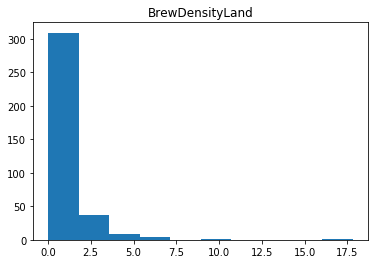

In [632]:
#df.loc[df['BrewDensity']>40, ['GeoFips','GeoName','  Population (persons)','BrewDensity','Number of Breweries']]
%matplotlib inline

x = 'BrewDensityLand'

plt.hist(df[x])
plt.title(x)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

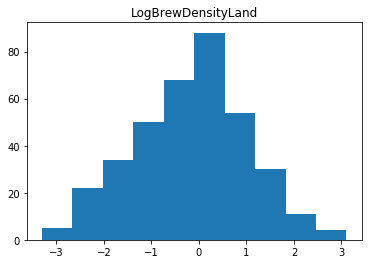

In [59]:
df['LogBrewDensityLand'] = np.log(df['BrewDensityLand']+.01)

plt.hist(df['LogBrewDensityLand'])
plt.title('LogBrewDensityLand')
plt.show

In [649]:
df['LogBrewDensityLand'].describe()

count    360.000000
mean      -0.536476
std        1.075864
min       -3.301241
25%       -1.299563
50%       -0.427049
75%        0.184949
max        2.880479
Name: LogBrewDensityLand, dtype: float64

### Take Logarithms of right-skewed variables

In [55]:
Rightskew =['  Per capita personal income',
       'Percentage of population 25 years and over with at least a Bachelor\'s degree (BA+)',
       'PopDensity', 'HousingDensity', 
        'BrewDensity', "BarsDensity","BarsDensityLand"]

Logged =['LogPerCapita_Income',
       'LogEducation',
       'LogPopDensity', 'LogHousingDensity', 
        'LogBrewDensity', "LogBarsDensity","LogBarsDensityLand"]

In [56]:
for i in range(len(Rightskew)):
    df[Logged] = np.log(df[Rightskew]+1)

In [57]:
df.head()

GeoFips                                            GeoName  \
0    10180        Abilene, TX (Metropolitan Statistical Area)   
1    10420          Akron, OH (Metropolitan Statistical Area)   
2    10500         Albany, GA (Metropolitan Statistical Area)   
3    10540         Albany, OR (Metropolitan Statistical Area)   
4    10580  Albany-Schenectady-Troy, NY (Metropolitan Stat...   

     Per capita personal income  Population  \
0                       41326.0    170219.0   
1                       47511.0    703505.0   
2                       36805.0    151434.0   
3                       40380.0    125047.0   
4                       55848.0    886188.0   

   Total employment (number of jobs)  Jobs-Population Ratio   Latitude  \
0                           103969.0               0.610796  32.448736   
1                           429591.0               0.610644  41.081445   
2                            83727.0               0.552894  31.578507   
3                            60760.0               0.485897  44.636511   
4                           569738.0               0.642909  42.652579   

    Longitude  \
0  -99.733144   
1  -81.519005   
2  -84.155741   
3 -123.105928   
4  -73.756232   

   Percentage of population 25 years and over with at least a Bachelor's degree (BA+)  \
0                                               21.5                                    
1                                               30.8                                    
2                                               19.5                                    
3                                               18.6                                    
4                                               36.2                                    

   PopDensity  HousingDensity  LandAreaSqMiles  PercentFemale  Percent25_44  \
0   60.234516       25.413373      2743.477960      49.369231     25.868047   
1  781.221565      347.262540       900.129131      51.408449     23.976326   
2   81.398925       34.182705      1932.557029      52.627198     25.226303   
3   50.945619       21.318020      2290.129168      50.644234     24.803839   
4  309.692164      139.886024      2811.554371      51.090420     24.554749   

   Number of Bars  BarsDensity  BarsDensityLand  Number of Breweries  \
0              27    15.861919         0.984152                   12   
1              50     7.107270         5.554759                   43   
2              19    12.546720         0.983153                    2   
3              50    39.984966         2.183283                   27   
4              48     5.416458         1.707241                   41   

   BrewDensity  BrewDensityLand  LogPerCapita_Income  LogEducation  \
0     7.049742         0.437401            10.629271      3.113515   
1     6.112252         4.777092            10.768738      3.459466   
2     1.320707         0.103490            10.513416      3.020425   
3    21.591881         1.178973            10.606115      2.975530   
4     4.626558         1.458268            10.930407      3.616309   

   LogPopDensity  LogHousingDensity  LogBrewDensity  LogBarsDensity  \
0       4.114711           3.273870        2.085640        2.825058   
1       6.662138           5.852957        1.961819        2.092761   
2       4.411572           3.560555        0.841872        2.606144   
3       3.950197           3.105394        3.117591        3.713205   
4       5.738803           4.947951        1.727498        1.858866   

   LogBarsDensityLand  
0            0.685192  
1            1.880191  
2            0.684688  
3            1.157913  
4            0.995930

## Divide MSAs into income categories by quartiles

In [519]:
def graph_by_quartiles(col,category):
    a = np.array(df[col])
    p25 = np.percentile(a, 25)
    p50 = np.percentile(a, 50)
    p75 = np.percentile(a, 75)

    df[category] = np.where(df[col]>=p25, 'MidLow', 'Low')
    df[category] = np.where(df[col]>=p50, 'MidHigh', df[category])
    df[category] = np.where(df[col]>=p75, 'High', df[category])
    graph = sns.boxplot(x=category, y='LogBrewDensityLand', data=df, order=["Low","MidLow","MidHigh","High"])
    
    return(graph)

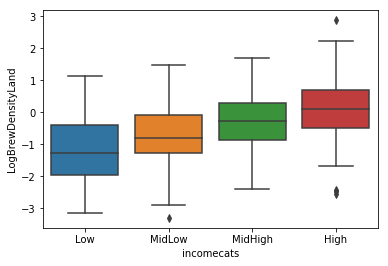

In [540]:
graph_by_quartiles(col='LogPerCapita_Income', category = "incomecats")

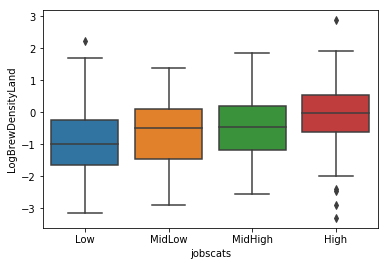

In [541]:
col='Jobs-Population Ratio'
category = 'jobscats'
graph_by_quartiles(col, category)

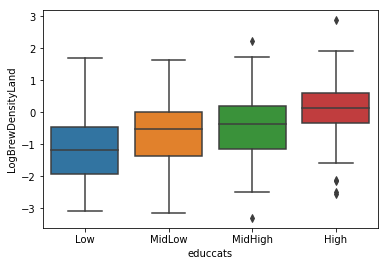

In [542]:
col='LogEducation'
category = 'educcats'
graph_by_quartiles(col, category)

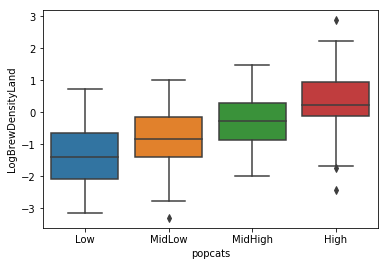

In [543]:
col='LogPopDensity'
category = 'popcats'
graph_by_quartiles(col, category)

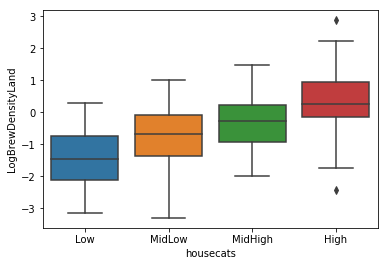

In [544]:
col='LogHousingDensity'
category = 'housecats'
graph_by_quartiles(col, category)

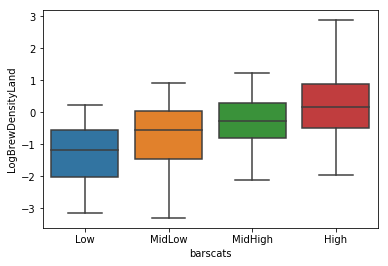

In [587]:
col='LogBarsDensityLand'
category = 'barscats'
graph_by_quartiles(col, category)

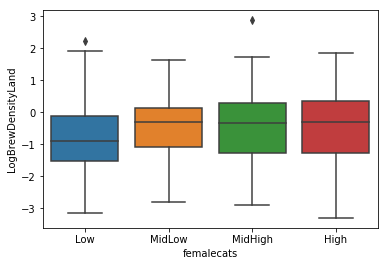

In [639]:
col='PercentFemale'
category = 'femalecats'
graph_by_quartiles(col, category)

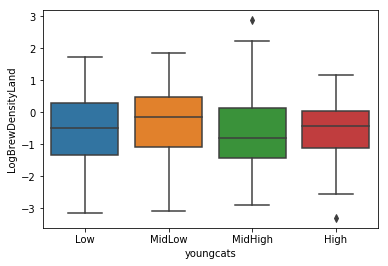

In [640]:
col='Percent25_44'
category = 'youngcats'
graph_by_quartiles(col, category)

## Correlations and Scatterplots

### Correlations

In [642]:
df[['LogBrewDensity','Jobs-Population Ratio',
       'LogPerCapita_Income', 'LogEducation', 'LogPopDensity',
       'LogHousingDensity','LogBarsDensityLand','PercentFemale','Percent25_44']].corr()

LogBrewDensity  Jobs-Population Ratio  \
LogBrewDensity               1.000000               0.289409   
Jobs-Population Ratio        0.289409               1.000000   
LogPerCapita_Income          0.159300               0.596736   
LogEducation                 0.281412               0.640517   
LogPopDensity               -0.258632               0.100503   
LogHousingDensity           -0.237811               0.100945   
LogBarsDensityLand           0.276059              -0.009115   
PercentFemale               -0.181917               0.001934   
Percent25_44                -0.135940               0.362308   

                       LogPerCapita_Income  LogEducation  LogPopDensity  \
LogBrewDensity                    0.159300      0.281412      -0.258632   
Jobs-Population Ratio             0.596736      0.640517       0.100503   
LogPerCapita_Income               1.000000      0.638128       0.341426   
LogEducation                      0.638128      1.000000       0.267027   
LogPopDensity                     0.341426      0.267027       1.000000   
LogHousingDensity                 0.357108      0.282537       0.991427   
LogBarsDensityLand                0.025955      0.015958       0.434387   
PercentFemale                     0.008722      0.082164       0.353345   
Percent25_44                      0.150998      0.186816       0.061526   

                       LogHousingDensity  LogBarsDensityLand  PercentFemale  \
LogBrewDensity                 -0.237811            0.276059      -0.181917   
Jobs-Population Ratio           0.100945           -0.009115       0.001934   
LogPerCapita_Income             0.357108            0.025955       0.008722   
LogEducation                    0.282537            0.015958       0.082164   
LogPopDensity                   0.991427            0.434387       0.353345   
LogHousingDensity               1.000000            0.460016       0.386250   
LogBarsDensityLand              0.460016            1.000000       0.103533   
PercentFemale                   0.386250            0.103533       1.000000   
Percent25_44                   -0.009572           -0.385904      -0.266179   

                       Percent25_44  
LogBrewDensity            -0.135940  
Jobs-Population Ratio      0.362308  
LogPerCapita_Income        0.150998  
LogEducation               0.186816  
LogPopDensity              0.061526  
LogHousingDensity         -0.009572  
LogBarsDensityLand        -0.385904  
PercentFemale             -0.266179  
Percent25_44               1.000000

In [641]:
df[['LogBrewDensityLand','Jobs-Population Ratio',
       'LogPerCapita_Income', 'LogEducation', 'LogPopDensity',
       'LogHousingDensity','LogBarsDensityLand','PercentFemale','Percent25_44']].corr()

LogBrewDensityLand  Jobs-Population Ratio  \
LogBrewDensityLand               1.000000               0.316809   
Jobs-Population Ratio            0.316809               1.000000   
LogPerCapita_Income              0.403923               0.596736   
LogEducation                     0.446713               0.640517   
LogPopDensity                    0.605621               0.100503   
LogHousingDensity                0.613650               0.100945   
LogBarsDensityLand               0.581067              -0.009115   
PercentFemale                    0.128710               0.001934   
Percent25_44                    -0.040269               0.362308   

                       LogPerCapita_Income  LogEducation  LogPopDensity  \
LogBrewDensityLand                0.403923      0.446713       0.605621   
Jobs-Population Ratio             0.596736      0.640517       0.100503   
LogPerCapita_Income               1.000000      0.638128       0.341426   
LogEducation                      0.638128      1.000000       0.267027   
LogPopDensity                     0.341426      0.267027       1.000000   
LogHousingDensity                 0.357108      0.282537       0.991427   
LogBarsDensityLand                0.025955      0.015958       0.434387   
PercentFemale                     0.008722      0.082164       0.353345   
Percent25_44                      0.150998      0.186816       0.061526   

                       LogHousingDensity  LogBarsDensityLand  PercentFemale  \
LogBrewDensityLand              0.613650            0.581067       0.128710   
Jobs-Population Ratio           0.100945           -0.009115       0.001934   
LogPerCapita_Income             0.357108            0.025955       0.008722   
LogEducation                    0.282537            0.015958       0.082164   
LogPopDensity                   0.991427            0.434387       0.353345   
LogHousingDensity               1.000000            0.460016       0.386250   
LogBarsDensityLand              0.460016            1.000000       0.103533   
PercentFemale                   0.386250            0.103533       1.000000   
Percent25_44                   -0.009572           -0.385904      -0.266179   

                       Percent25_44  
LogBrewDensityLand        -0.040269  
Jobs-Population Ratio      0.362308  
LogPerCapita_Income        0.150998  
LogEducation               0.186816  
LogPopDensity              0.061526  
LogHousingDensity         -0.009572  
LogBarsDensityLand        -0.385904  
PercentFemale             -0.266179  
Percent25_44               1.000000

### Scatterplots

(-4, 3.1904607611671714)

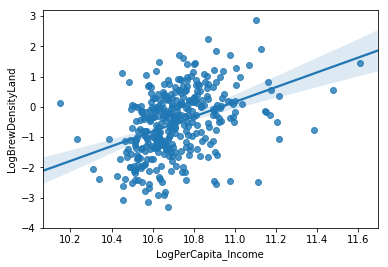

In [650]:
sns.regplot(x="LogPerCapita_Income", y="LogBrewDensityLand", data=df)
plt.ylim(-4,)

(-4, 3.1904607611671714)

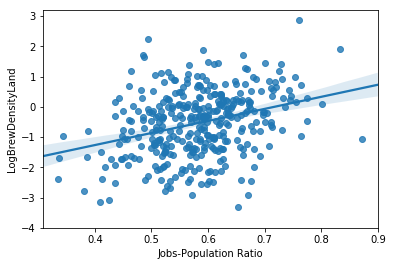

In [651]:
sns.regplot(x="Jobs-Population Ratio", y="LogBrewDensityLand", data=df)
plt.ylim(-4,)

(-4, 3.1904607611671714)

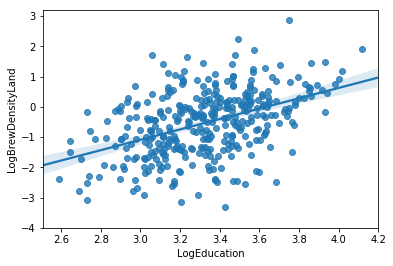

In [652]:
sns.regplot(x="LogEducation", y="LogBrewDensityLand", data=df)
plt.ylim(-4,)

(-4, 3.1904607611671714)

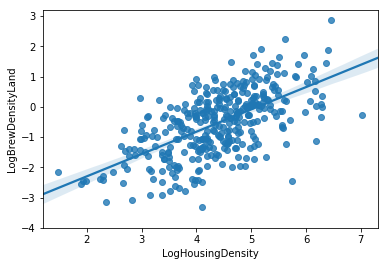

In [654]:
sns.regplot(x='LogHousingDensity', y="LogBrewDensityLand", data=df)
plt.ylim(-4,)


(-4, 3.1935101277043505)

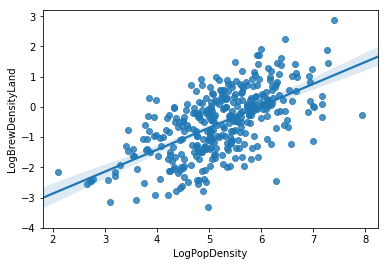

In [653]:
sns.regplot(x='LogPopDensity', y="LogBrewDensityLand", data=df)
plt.ylim(-4,)

(-4, 3.1904607611671714)

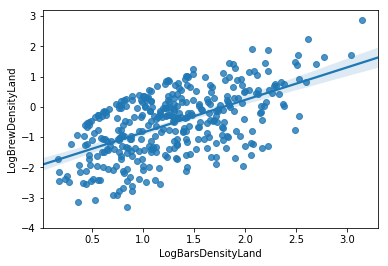

In [655]:
sns.regplot(x='LogBarsDensityLand', y="LogBrewDensityLand", data=df)
plt.ylim(-4,)

(-4, 3.1904607611671714)

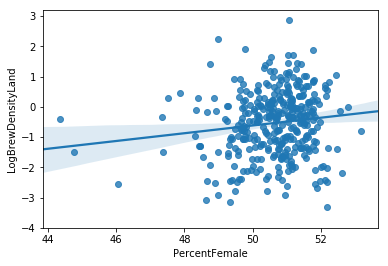

In [656]:
sns.regplot(x='PercentFemale', y="LogBrewDensityLand", data=df)
plt.ylim(-4,)

(-4, 3.1904607611671714)

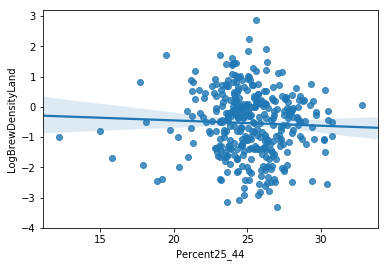

In [648]:
sns.regplot(x='Percent25_44', y="LogBrewDensityLand", data=df)
plt.ylim(-4,)

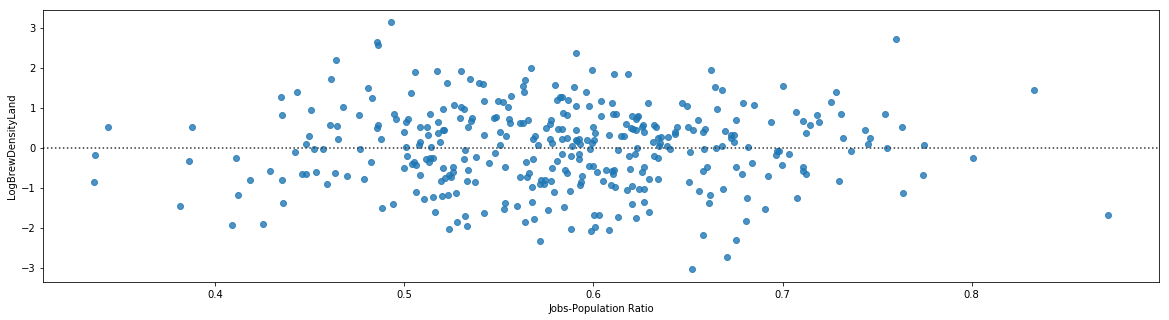

In [552]:
width = 20
height = 5
plt.figure(figsize=(width, height))
sns.residplot(df['Jobs-Population Ratio'], df['LogBrewDensityLand'])
plt.show()

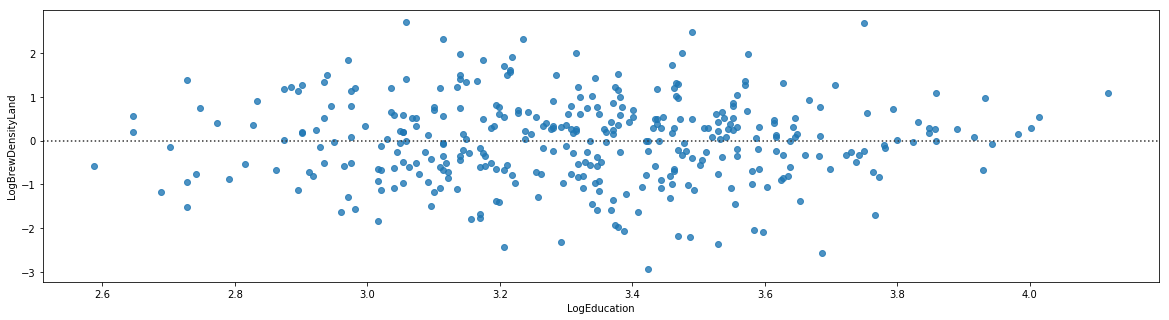

In [553]:
width = 20
height = 5
plt.figure(figsize=(width, height))
sns.residplot(df['LogEducation'], df['LogBrewDensityLand'])
plt.show()

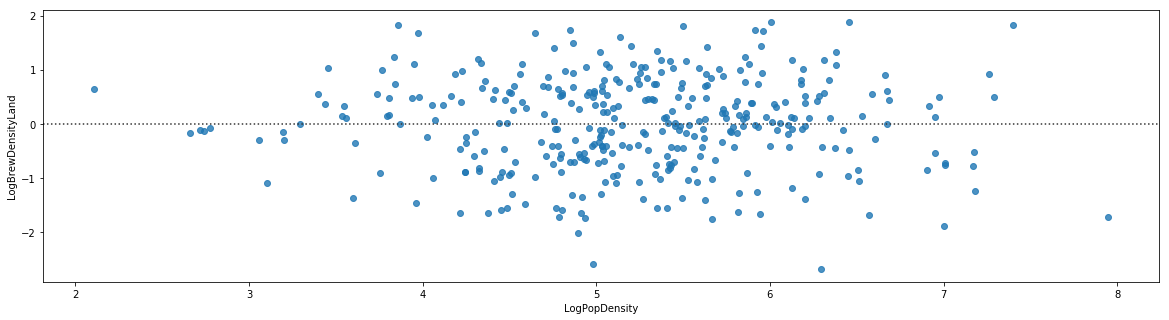

In [554]:
width = 20
height = 5
plt.figure(figsize=(width, height))
sns.residplot(df['LogPopDensity'], df['LogBrewDensityLand'])
plt.show()

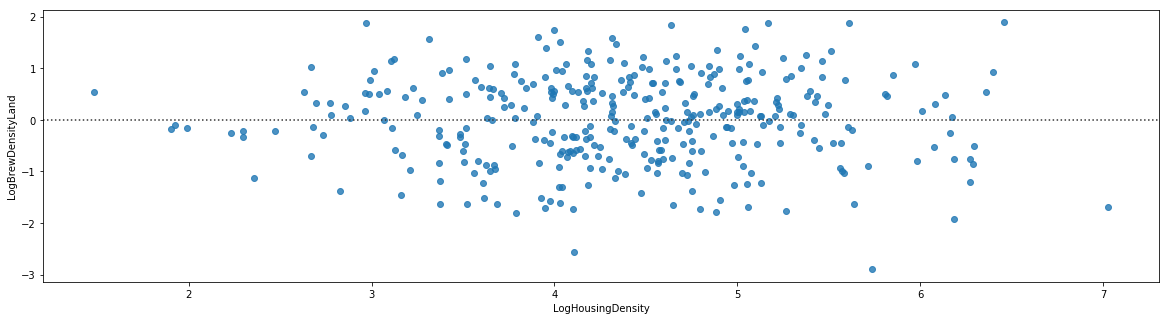

In [555]:
width = 20
height = 5
plt.figure(figsize=(width, height))
sns.residplot(df['LogHousingDensity'], df['LogBrewDensityLand'])
plt.show()

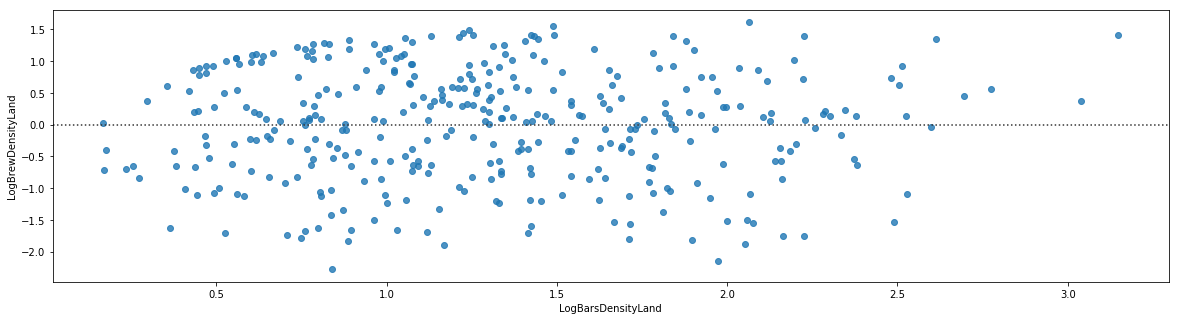

In [591]:
width = 20
height = 5
plt.figure(figsize=(width, height))
sns.residplot(df['LogBarsDensityLand'], df['LogBrewDensityLand'])
plt.show()

## Multiple Regression

In [491]:
df.columns

Index(['GeoFips', 'GeoName', '  Per capita personal income', 'Population',
       'Total employment (number of jobs)', 'Jobs-Population Ratio',
       'Latitude', 'Longitude',
       'Percentage of population 25 years and over with at least a Bachelor's degree (BA+)',
       'PopDensity', 'HousingDensity', 'LandAreaSqMiles', 'Number of Bars',
       'BarsDensity', 'BarsDensityLand', 'Number of Breweries', 'BrewDensity',
       'BrewDensityLand', 'LogPerCapita_Income', 'LogEducation',
       'LogPopDensity', 'LogHousingDensity', 'LogBrewDensity',
       'LogBrewDensityLand', 'incomecats', 'jobscats', 'educcats', 'popcats',
       'housecats'],
      dtype='object')

In [61]:
lm = LinearRegression(normalize=True)
lm
Input=[('scale',StandardScaler())]

In [657]:
X = df[['Jobs-Population Ratio',
       'LogPerCapita_Income', 'LogEducation', 'LogPopDensity',
       'LogHousingDensity','LogBarsDensityLand',
       'PercentFemale','Percent25_44']]
Y = df['LogBrewDensityLand']
lm.fit(X,Y)
print('Intercept =', lm.intercept_)
print('Slopes =', lm.coef_)
print('The R-squared is: ', lm.score(X, Y))

Intercept = -9.810768298201483
Slopes = [ 1.00893437  0.41995276  1.02975632  0.75060569 -0.36236685  0.81879376
 -0.04856217 -0.00612044]
The R-squared is:  0.61908832648019


In [658]:
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:     LogBrewDensityLand   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     71.31
Date:                Fri, 21 Jun 2019   Prob (F-statistic):           6.08e-69
Time:                        17:38:36   Log-Likelihood:                -362.91
No. Observations:                 360   AIC:                             743.8
Df Residuals:                     351   BIC:                             778.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -9.81

C:\Users\gabriel.martinez\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [594]:
X = df[['Jobs-Population Ratio',
       'LogPerCapita_Income', 'LogPopDensity','LogBarsDensityLand'
       ]]
Y = df['LogBrewDensityLand']
lm.fit(X,Y)
print('Intercept =', lm.intercept_)
print('Slopes =', lm.coef_)
print('The R-squared is: ', lm.score(X, Y))

Intercept = -15.598086677578541
Slopes = [2.38682131 0.97966788 0.41289564 0.79503266]
The R-squared is:  0.5835033526447841


In [595]:
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:     LogBrewDensityLand   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     124.3
Date:                Fri, 21 Jun 2019   Prob (F-statistic):           3.17e-66
Time:                        16:16:20   Log-Likelihood:                -378.98
No. Observations:                 360   AIC:                             768.0
Df Residuals:                     355   BIC:                             787.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -15.59

C:\Users\gabriel.martinez\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [98]:
X = df[['Jobs-Population Ratio',
       'LogEducation',
       'LogHousingDensity','LogBarsDensityLand']]
Y = df['LogBrewDensityLand']
est2 = lm.fit(X,Y)
print('Intercept =', lm.intercept_)
print('Slopes =', lm.coef_)
print('The R-squared is: ', lm.score(X, Y))

Intercept = -6.880821989282743
Slopes = [0.66232169 0.96010408 0.39531466 1.05703858]
The R-squared is:  0.6407592918388079


In [99]:
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:     LogBrewDensityLand   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     161.0
Date:                Tue, 25 Jun 2019   Prob (F-statistic):           6.52e-79
Time:                        14:23:48   Log-Likelihood:                -389.11
No. Observations:                 366   AIC:                             788.2
Df Residuals:                     361   BIC:                             807.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -6.88

C:\Users\gabriel.martinez\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## Predict Brewery Density on the basis of Job-Population Ratio and % of Population with at least a BA

In [64]:
Yhat=lm.predict(X)
Yhat[0:5]

array([-1.46849702,  1.14626269, -1.48342452, -1.25061687,  0.02575723])

<function matplotlib.pyplot.show(*args, **kw)>

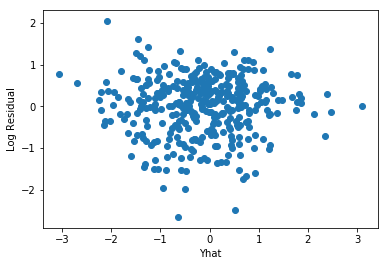

In [65]:
df['Log_Residual']= df.LogBrewDensityLand - Yhat
plt.scatter(Yhat,df.Log_Residual)
plt.xlabel("Yhat")
plt.ylabel("Log Residual")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

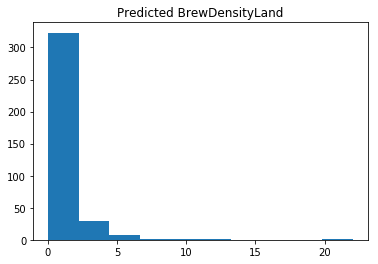

In [66]:
df['Predicted BrewDensityLand'] = np.exp(Yhat-.01)
plt.hist(df['Predicted BrewDensityLand'])
plt.title('Predicted BrewDensityLand')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

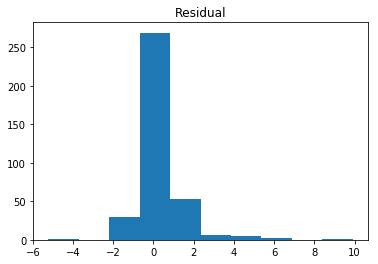

In [67]:
df['Residual'] = df['BrewDensityLand'] - df['Predicted BrewDensityLand']
plt.hist(df['Residual'])
plt.title('Residual')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

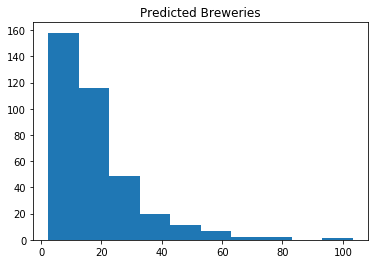

In [68]:
df['Predicted Breweries']= df['Predicted BrewDensityLand']*df['LandAreaSqMiles']/100

plt.hist(df['Predicted Breweries'])
plt.title('Predicted Breweries')
plt.show

In [69]:
df.columns

Index(['GeoFips', 'GeoName', '  Per capita personal income', 'Population',
       'Total employment (number of jobs)', 'Jobs-Population Ratio',
       'Latitude', 'Longitude',
       'Percentage of population 25 years and over with at least a Bachelor's degree (BA+)',
       'PopDensity', 'HousingDensity', 'LandAreaSqMiles', 'PercentFemale',
       'Percent25_44', 'Number of Bars', 'BarsDensity', 'BarsDensityLand',
       'Number of Breweries', 'BrewDensity', 'BrewDensityLand',
       'LogPerCapita_Income', 'LogEducation', 'LogPopDensity',
       'LogHousingDensity', 'LogBrewDensity', 'LogBarsDensity',
       'LogBarsDensityLand', 'LogBrewDensityLand', 'Log_Residual',
       'Predicted BrewDensityLand', 'Residual', 'Predicted Breweries'],
      dtype='object')

<function matplotlib.pyplot.show(*args, **kw)>

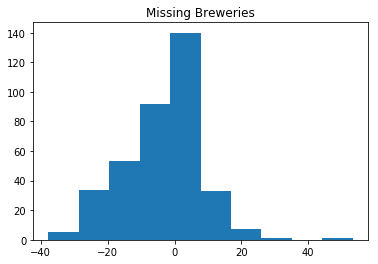

In [70]:
df['Missing Breweries']= df['Predicted Breweries'] - df['Number of Breweries']
plt.hist(df['Missing Breweries'])
plt.title('Missing Breweries')
plt.show

In [71]:
df[['GeoName',
    '  Per capita personal income',
    'Jobs-Population Ratio',
    'Percentage of population 25 years and over with at least a Bachelor\'s degree (BA+)',
    'PopDensity',
    'HousingDensity',
    'BarsDensityLand', 
    'BrewDensityLand',
    'Predicted BrewDensityLand',
    'Predicted Breweries',
    'Number of Breweries',
    'Missing Breweries'
   ]].head()

GeoName  \
0        Abilene, TX (Metropolitan Statistical Area)   
1          Akron, OH (Metropolitan Statistical Area)   
2         Albany, GA (Metropolitan Statistical Area)   
3         Albany, OR (Metropolitan Statistical Area)   
4  Albany-Schenectady-Troy, NY (Metropolitan Stat...   

     Per capita personal income  Jobs-Population Ratio  \
0                       41326.0               0.610796   
1                       47511.0               0.610644   
2                       36805.0               0.552894   
3                       40380.0               0.485897   
4                       55848.0               0.642909   

   Percentage of population 25 years and over with at least a Bachelor's degree (BA+)  \
0                                               21.5                                    
1                                               30.8                                    
2                                               19.5                                    
3                                               18.6                                    
4                                               36.2                                    

   PopDensity  HousingDensity  BarsDensityLand  BrewDensityLand  \
0   60.234516       25.413373         0.984152         0.437401   
1  781.221565      347.262540         5.554759         4.777092   
2   81.398925       34.182705         0.983153         0.103490   
3   50.945619       21.318020         2.183283         1.178973   
4  309.692164      139.886024         1.707241         1.458268   

   Predicted BrewDensityLand  Predicted Breweries  Number of Breweries  \
0                   0.227980             6.254583                   12   
1                   3.115104            28.039963                   43   
2                   0.224602             4.340565                    2   
3                   0.283479             6.492038                   27   
4                   1.015882            28.562076                   41   

   Missing Breweries  
0          -5.745417  
1         -14.960037  
2           2.340565  
3         -20.507962  
4         -12.437924

In [97]:
df['MissingBrew_Percentage'] = df['Missing Breweries']/df['Predicted Breweries']*100
df.loc[(df['Missing Breweries']>12) & (df['Number of Breweries']<20), ['GeoName','Population','BrewDensity','Predicted BrewDensity',"Residual",'Number of Breweries','Predicted Breweries','Missing Breweries','MissingBrew_Percentage']]
#df.loc[df['  Population (persons)']>2000000, ['GeoName','  Population (persons)','BrewDensity',"Residual",'Number of Breweries','Missing Breweries']]
#df.head()

GeoName  Population  \
16   Athens-Clarke County, GA (Metropolitan Statist...    209271.0   
125    Gainesville, FL (Metropolitan Statistical Area)    284687.0   
150  Hilton Head Island-Bluffton-Beaufort, SC (Metr...    215302.0   
163        Jackson, MS (Metropolitan Statistical Area)    578715.0   
216  Memphis, TN-MS-AR (Metropolitan Statistical Area)   1348260.0   
229     Montgomery, AL (Metropolitan Statistical Area)    373903.0   
243  North Port-Sarasota-Bradenton, FL (Metropolita...    804690.0   
326    Tallahassee, FL (Metropolitan Statistical Area)    382627.0   

     BrewDensity  Predicted BrewDensity  Residual  Number of Breweries  \
16      1.911397                    NaN -1.421987                    4   
125     2.458841                    NaN -1.264307                    7   
150     3.251247                    NaN -0.980206                    7   
163     0.172797                    NaN -0.496080                    1   
216     0.519188                    NaN -0.401189                    7   
229     0.534898                    NaN -0.527575                    2   
243     0.621357                    NaN -1.689165                    5   
326     1.568107                    NaN -0.634734                    6   

     Predicted Breweries  Missing Breweries  MissingBrew_Percentage  
16             18.572701          14.572701               78.463014  
125            22.483931          15.483931               68.866655  
150            19.072197          12.072197               63.297360  
163            19.484631          18.484631               94.867750  
216            25.365844          18.365844               72.403835  
229            16.313525          14.313525               87.740234  
243            26.938858          21.938858               81.439451  
326            21.155531          15.155531               71.638622

In [100]:
MissingBreweries = df.loc[(df['Missing Breweries']>4) & (df['Number of Breweries']<20), ['Latitude','Longitude','GeoName','Missing Breweries','Number of Breweries']]
MissingBreweries

Latitude   Longitude                                            GeoName  \
6    31.311294  -92.445137     Alexandria, LA (Metropolitan Statistical Area)   
9    35.221997 -101.831297       Amarillo, TX (Metropolitan Statistical Area)   
16   33.950000  -83.383333  Athens-Clarke County, GA (Metropolitan Statist...   
19   32.609857  -85.480782  Auburn-Opelika, AL (Metropolitan Statistical A...   
29   30.080174  -94.126556  Beaumont-Port Arthur, TX (Metropolitan Statist...   
35   33.520661  -86.802490  Birmingham-Hoover, AL (Metropolitan Statistica...   
43   36.968522  -86.480804  Bowling Green, KY (Metropolitan Statistical Area)   
46   25.901747  -97.497484  Brownsville-Harlingen, TX (Metropolitan Statis...   
59   38.349820  -81.632623     Charleston, WV (Metropolitan Statistical Area)   
66   39.728494 -121.837478          Chico, CA (Metropolitan Statistical Area)   
72   30.627977  -96.334407  College Station-Bryan, TX (Metropolitan Statis...   
75   34.000710  -81.034814       Columbia, SC (Metropolitan Statistical Area)   
86   30.603525  -87.903605  Daphne-Fairhope-Foley, AL (Metropolitan Statis...   
107  42.129224  -80.085059           Erie, PA (Metropolitan Statistical Area)   
116  43.012527  -83.687456          Flint, MI (Metropolitan Statistical Area)   
118  34.799810  -87.677251  Florence-Muscle Shoals, AL (Metropolitan Stati...   
125  29.651634  -82.324826    Gainesville, FL (Metropolitan Statistical Area)   
139  35.612661  -77.366354     Greenville, NC (Metropolitan Statistical Area)   
141  30.367420  -89.092816  Gulfport-Biloxi-Pascagoula, MS (Metropolitan S...   
148  31.327119  -89.290339    Hattiesburg, MS (Metropolitan Statistical Area)   
150  32.216316  -80.752608  Hilton Head Island-Bluffton-Beaufort, SC (Metr...   
152  28.803706  -82.576137  Homosassa Springs, FL (Metropolitan Statistica...   
153  34.503700  -93.055179    Hot Springs, AR (Metropolitan Statistical Area)   
156  38.419250  -82.445154  Huntington-Ashland, WV-KY-OH (Metropolitan Sta...   
157  34.730369  -86.586104     Huntsville, AL (Metropolitan Statistical Area)   
163  32.298757  -90.184810        Jackson, MS (Metropolitan Statistical Area)   
168  38.576702  -92.173516  Jefferson City, MO (Metropolitan Statistical A...   
171  35.842297  -90.704279      Jonesboro, AR (Metropolitan Statistical Area)   
173  20.889335 -156.472947  Kahului-Wailuku-Lahaina, HI (Metropolitan Stat...   
182  40.486427  -86.133603         Kokomo, IN (Metropolitan Statistical Area)   
183  43.801356  -91.239581  La Crosse-Onalaska, WI-MN (Metropolitan Statis...   
184  30.224090  -92.019843      Lafayette, LA (Metropolitan Statistical Area)   
185  30.226595  -93.217376   Lake Charles, LA (Metropolitan Statistical Area)   
187  28.039465  -81.949804  Lakeland-Winter Haven, FL (Metropolitan Statis...   
198  38.040584  -84.503716  Lexington-Fayette, KY (Metropolitan Statistica...   
199  40.742551  -84.105226           Lima, OH (Metropolitan Statistical Area)   
211  39.183608  -96.571669      Manhattan, KS (Metropolitan Statistical Area)   
212  44.163578  -93.999400  Mankato-North Mankato, MN (Metropolitan Statis...   
216  35.149534  -90.048980  Memphis, TN-MS-AR (Metropolitan Statistical Area)   
220  43.615583  -84.247212        Midland, MI (Metropolitan Statistical Area)   
225  30.695366  -88.039891         Mobile, AL (Metropolitan Statistical Area)   
229  32.366805  -86.299969     Montgomery, AL (Metropolitan Statistical Area)   
237  26.142036  -81.794810  Naples-Immokalee-Marco Island, FL (Metropolita...   
243  27.044224  -82.235925  North Port-Sarasota-Bradenton, FL (Metropolita...   
245  29.187199  -82.140092          Ocala, FL (Metropolitan Statistical Area)   
256  28.034462  -80.588665  Palm Bay-Melbourne-Titusville, FL (Metropolita...   
257  30.158813  -85.660206    Panama City, FL (Metropolitan Statistical Area)   
258  39.266742  -81.561513  Parkersburg-Vienna, WV (Metropolitan Statistic...   
259  30.421309  -87.216915  Pensacola

In [101]:
MissingBreweries.shape

(68, 5)

In [95]:
# create map of US using latitude and longitude values
uslatitude = latitude - 3
uslongitude = longitude + 4.6
map_us = folium.Map(location=[uslatitude, uslongitude], zoom_start=5)

# add markers to map
for lat, lng, GeoName, Missing in zip(MissingBreweries['Latitude'], MissingBreweries['Longitude'], MissingBreweries['GeoName'], MissingBreweries['Missing Breweries']):
    label = '{}, {}'.format(GeoName, Missing)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=Missing,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_us)  
map_us

The majority of towns that are "underserved" seem to be in the Southeast.